In [1]:
!pip install tqdm

In [2]:
import cobra
import numpy as np
from tqdm import tqdm
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

# Dynamic Flux Based Analaysis

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Maximize
1.0*BIOMASS_SC4_bal - 1.0*BIOMASS_SC4_bal_reverse_bb385
Maximum productivity = 19.46467518075362 mmol/gDW*h
Maximum theoretical yield = 0.0973233759037681 mmol-EPA/mmol-glc
Objective of model is = Maximize
1.0*BIOMASS_SC4_bal - 1.0*BIOMASS_SC4_bal_reverse_bb385
Maximum theoretical biomass productivity: 0.09732337590376837 /h
Maximum theoretical productivity of EPA: 0.15900233826968102 mmol/gDW*h
Maximum theoretical biomass productivity: 6.385230506882285 /h
Maximum theoretical productivity of EPA pathway reaction: 9.796860572483833 mmol/gDW*h
Maximum theoretical biomass productivity: 5.16881956975369 /h
Maximum theoretical productivity of EPA pathway reaction: 8.062088428974636 mmol/gDW*h
Maximum theoretical biomass productivity: 4.4920703922914145 /h
Maximum theoretical productivity of EPA pathway reaction: 7.213930348258664 mmol/gDW*h

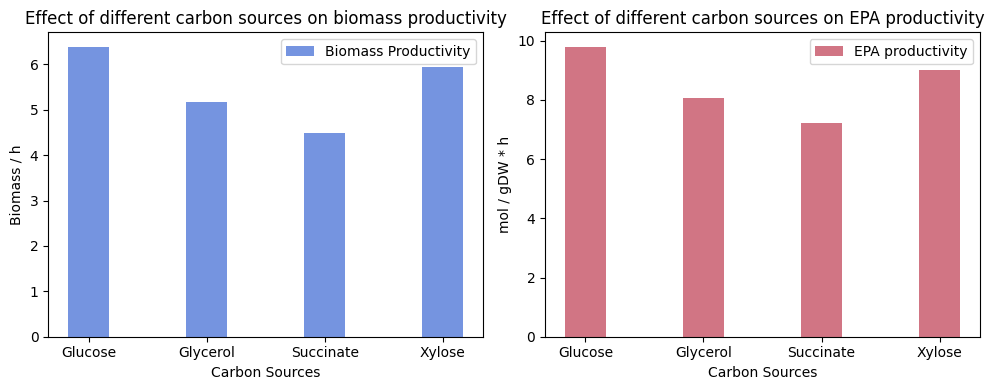

Maximum theoretical biomass productivity: 6.171779630339661 /h
Maximum theoretical productivity of EPA pathway reaction: 9.409048938134887 mmol/gDW*h


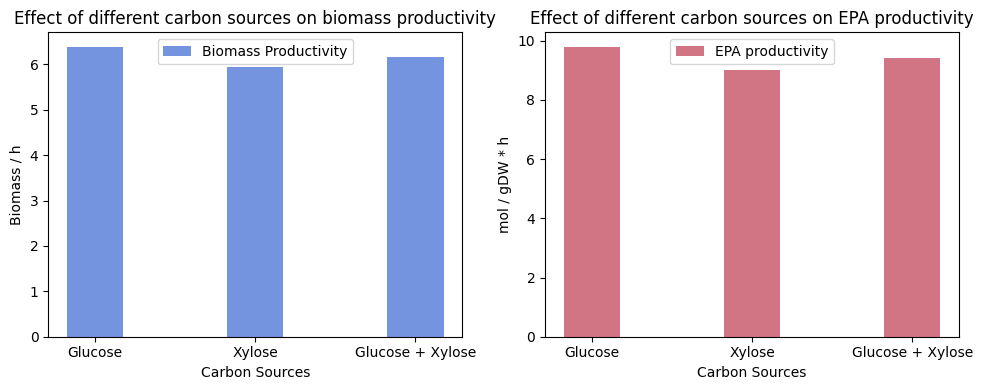

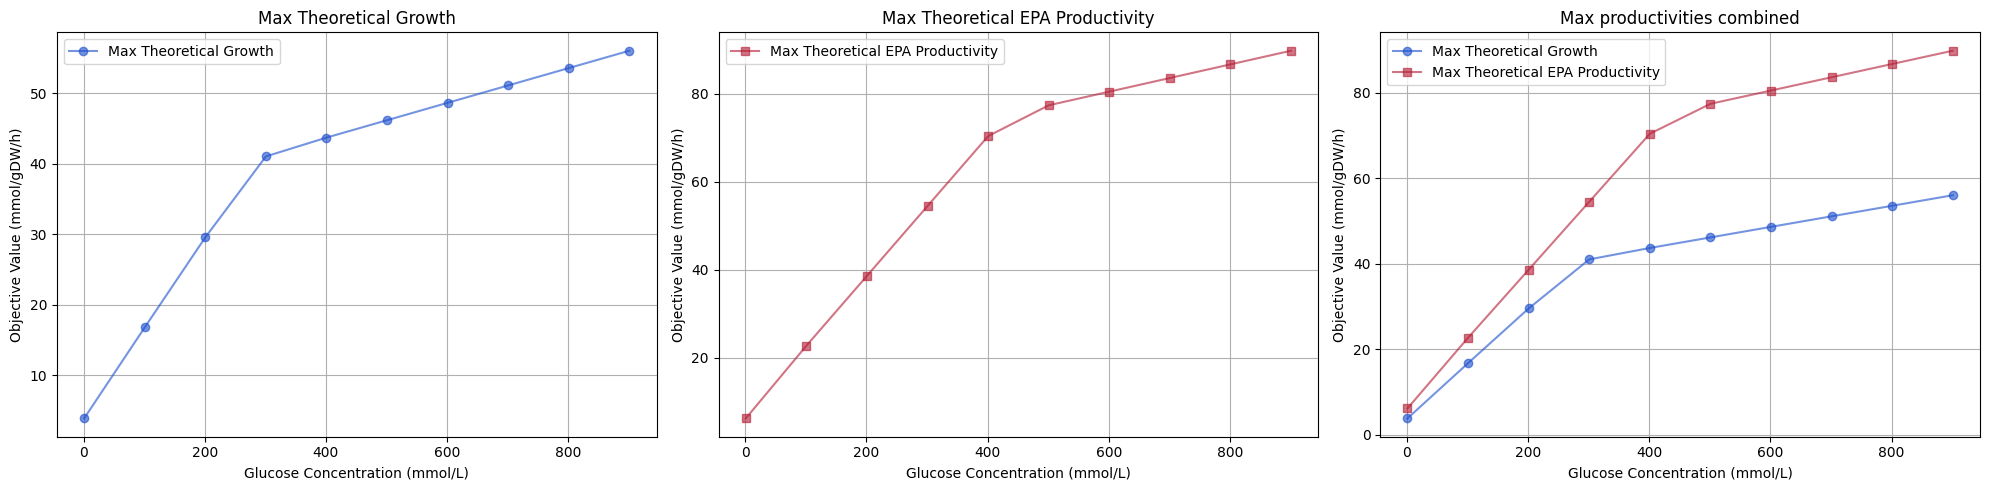

In [3]:
%run Medium_Opt_New_Model.ipynb #Loading the model

In [4]:

model.medium
glucose = model.reactions.EX_glc__D_e
biomass = model.reactions.BIOMASS_SC4_bal

Medium should be loaded directly from the optimized section

In [5]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_SC4_bal', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 1, 5)  # Desired integration resolution and interval
y0 = [0.1, 2]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 0.036: : 35it [01:37,  2.64s/it]

In [ ]:
sol

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')